<a href="https://colab.research.google.com/github/gguex/ISH_ressources_cours_ML/blob/main/TP09c_corrige.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import os

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
cifar10_train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2023, 0.1994, 0.2010)
    )
])
cifar10_test_transforms = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2023, 0.1994, 0.2010)
    )
])

In [4]:
cifar10_tv = datasets.CIFAR10(root="./cifar10_train/",
                              train=True,
                              download=True,
                              transform=cifar10_train_transforms)
cifar10_test = datasets.CIFAR10(root="./cifar10_test/",
                                train=False,
                                download=True,
                                transform=cifar10_test_transforms)

100%|██████████| 170M/170M [00:07<00:00, 23.8MB/s]


Extracting ./cifar10_train/cifar-10-python.tar.gz to ./cifar10_train/


100%|██████████| 170M/170M [00:09<00:00, 17.6MB/s]


Extracting ./cifar10_test/cifar-10-python.tar.gz to ./cifar10_test/


In [5]:
valid_ratio = 0.1
valid_size = int(valid_ratio * len(cifar10_tv))
train_size = len(cifar10_tv) - valid_size
cifar10_train, cifar10_valid = random_split(cifar10_tv, [train_size, valid_size])
cifar10_valid.dataset.transform = cifar10_test_transforms

In [6]:
train_loader = DataLoader(cifar10_train, batch_size=100, shuffle=True)
valid_loader =  DataLoader(cifar10_valid, batch_size=100, shuffle=False)
test_loader = DataLoader(cifar10_test, batch_size=100, shuffle=False)

In [7]:
class MyConvNet(nn.Module):

  def __init__(self):
    super(MyConvNet, self).__init__()

    # Le module de convolutions
    self.convolutions = nn.Sequential(
        nn.Conv2d(in_channels=3,
                  out_channels=16,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=16,
                  out_channels=32,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=32,
                  out_channels=64,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    # Le module de classification
    self.classifier = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(in_features=4*4*64,
                  out_features=500),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(in_features=500,
                  out_features=10)

    )

  # La fonction qui fait passer les données dans la modèle
  def forward(self, x):
      y = self.convolutions(x)
      y_flat = y.flatten(1)
      z = self.classifier(y_flat)
      return z

In [8]:
my_convnet = MyConvNet()
my_convnet(cifar10_train[0][0].unsqueeze(0))

tensor([[-0.5011, -0.3715, -0.6721,  0.0997, -0.3256, -0.9398, -0.0662, -0.4147,
          0.1205, -0.1855]], grad_fn=<AddmmBackward0>)

In [9]:
checkpoints_dir = "checkpoints"
os.makedirs(checkpoints_dir, exist_ok=True)

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(my_convnet.parameters(), lr=0.001)

In [11]:
# Paramètres d'entrainement
n_epochs = 25

my_convnet = my_convnet.to(device)

train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
for epoch in range(n_epochs):

  # ---- Entrainement

  my_convnet.train()
  train_loss = 0
  train_correct = 0
  for inputs, labels in train_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      logit_outputs = my_convnet(inputs)
      loss = loss_fn(logit_outputs, labels)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
      train_correct += (logit_outputs.argmax(1) == labels).sum().item()

  # ---- Validation

  my_convnet.eval()
  valid_loss = 0
  valid_correct = 0
  for inputs, labels in valid_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      logit_outputs = my_convnet(inputs)
      loss = loss_fn(logit_outputs, labels)
      valid_loss += loss.item()
      valid_correct += (logit_outputs.argmax(1) == labels).sum().item()

  # ---- Engistrement et affichage

  # Calcul de la perte moyenne et exactitude moyenne
  train_mean_loss = train_loss / len(train_loader.dataset)
  valid_mean_loss = valid_loss / len(valid_loader.dataset)
  train_mean_accuracy = train_correct / len(train_loader.dataset)
  valid_mean_accuracy = valid_correct / len(valid_loader.dataset)

  # Sauvegarde des valeurs
  train_losses.append(train_mean_loss)
  valid_losses.append(valid_mean_loss)
  train_accuracies.append(train_mean_accuracy)
  valid_accuracies.append(valid_mean_accuracy)

  # Sauvegarde du checkpoint
  torch.save({"epoch": epoch + 1,
              "model_state_dict": my_convnet.state_dict(),
              "optimizer_tat_dict": optimizer.state_dict(),
              "train_loss": train_mean_loss,
              "valid_loss": valid_mean_loss,
              "train_accuracy": train_mean_accuracy,
              "valid_accuracy": valid_mean_accuracy},
             f"{checkpoints_dir}/model_{epoch + 1}.pt")

  # Print
  print(f"Epoch {epoch + 1}/{n_epochs} : "
            f"train loss = {train_mean_loss:.4f} "
            f"train accuracy = {train_mean_accuracy:.3%} "
            f"valid loss = {valid_mean_loss:.4f} "
            f"valid accuracy = {valid_mean_accuracy:.3%} ")


Epoch 1/25 : train loss = 0.0139 train accuracy = 49.249% valid loss = 0.0110 valid accuracy = 60.540% 
Epoch 2/25 : train loss = 0.0108 train accuracy = 61.531% valid loss = 0.0095 valid accuracy = 66.280% 
Epoch 3/25 : train loss = 0.0095 train accuracy = 66.240% valid loss = 0.0089 valid accuracy = 68.000% 
Epoch 4/25 : train loss = 0.0088 train accuracy = 69.027% valid loss = 0.0084 valid accuracy = 70.660% 
Epoch 5/25 : train loss = 0.0082 train accuracy = 71.109% valid loss = 0.0083 valid accuracy = 71.080% 
Epoch 6/25 : train loss = 0.0077 train accuracy = 72.764% valid loss = 0.0075 valid accuracy = 73.780% 
Epoch 7/25 : train loss = 0.0072 train accuracy = 74.267% valid loss = 0.0072 valid accuracy = 74.740% 
Epoch 8/25 : train loss = 0.0069 train accuracy = 75.560% valid loss = 0.0076 valid accuracy = 74.080% 
Epoch 9/25 : train loss = 0.0066 train accuracy = 76.658% valid loss = 0.0068 valid accuracy = 76.340% 
Epoch 10/25 : train loss = 0.0063 train accuracy = 77.638% valid

[]

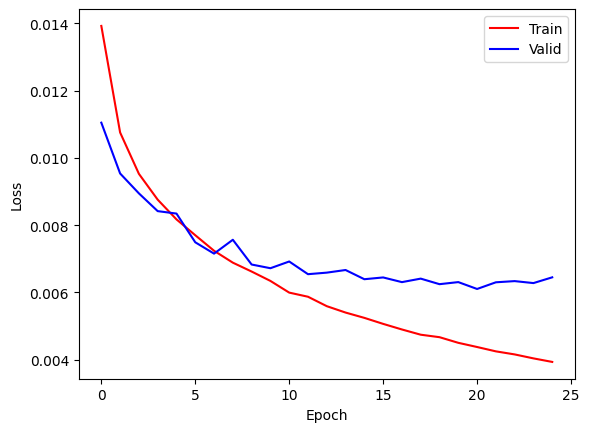

In [12]:
fig, ax = plt.subplots()
ax.plot(train_losses, c="red", label="Train")
ax.plot(valid_losses, c="blue", label="Valid")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
plt.plot()

[]

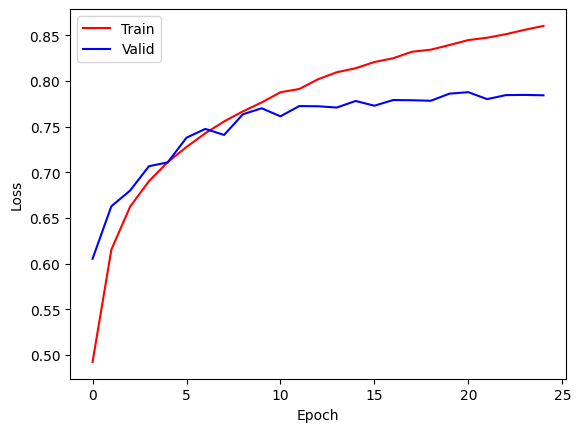

In [13]:
fig, ax = plt.subplots()
ax.plot(train_accuracies, c="red", label="Train")
ax.plot(valid_accuracies, c="blue", label="Valid")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
plt.plot()

In [14]:
best_epoch = 15
best_checkpoint = torch.load(f"{checkpoints_dir}/model_{best_epoch}.pt",
                             weights_only=True)
best_model = MyConvNet()
best_model.load_state_dict(best_checkpoint["model_state_dict"])
best_valid_accuracy = best_checkpoint["valid_accuracy"]
print(f"Validation accuracy = {best_valid_accuracy: .4%}")

Validation accuracy =  77.8000%


In [15]:
best_model.eval()
best_model.to(device)
test_correct = 0
for inputs, labels in test_loader:
  inputs = inputs.to(device)
  labels = labels.to(device)
  logit_outputs = best_model(inputs)
  test_correct += (logit_outputs.argmax(1) == labels).sum().item()

test_accuracy = test_correct / len(test_loader.dataset)
print(f"Test Accuracy = {test_accuracy: .4%}:")

Test Accuracy =  77.9500%:


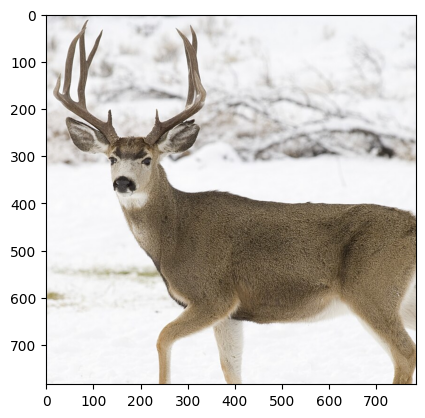

In [22]:
img = Image.open("/content/drive/MyDrive/Colab Notebooks/ml_data/TP9/example.png")
img = img.convert("RGB")
plt.imshow(img)

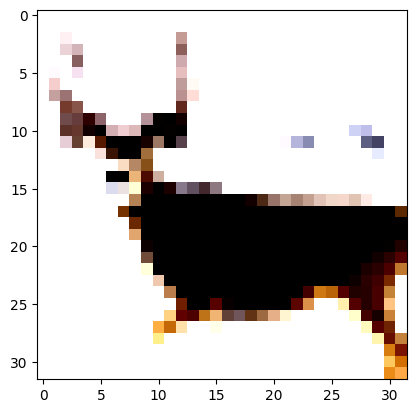

In [23]:
img_tensor = cifar10_test_transforms(img)
plt.imshow(img_tensor.permute(1, 2, 0))

In [24]:
img_batch = img_tensor.unsqueeze(0)
y = my_convnet(img_batch.to(device))
prob = torch.nn.functional.softmax(y, dim=1)[0]
_, indices = torch.sort(y, descending=True)
for i in indices[0]:
  print(cifar10_tv.classes[i], f": {prob[i].item():.2%}")

deer : 97.18%
bird : 1.49%
cat : 0.84%
dog : 0.16%
ship : 0.13%
horse : 0.09%
frog : 0.07%
airplane : 0.04%
truck : 0.00%
automobile : 0.00%
